# .NET Initialization
<div style="width:100%;height:6px;background-color:Black;"></div>

In [1]:
import clr
clr.AddReference(r"..\bin\MiniSim.Core")

import MiniSim.Core.Expressions as expr
from  MiniSim.Core.Flowsheeting import MaterialStream, Flowsheet
import MiniSim.Core.Numerics as num
from MiniSim.Core.UnitsOfMeasure import Unit, SI, METRIC, PhysicalDimension
from MiniSim.Core.ModelLibrary import Flash, Heater, Mixer, Splitter, EquilibriumStageSection
import MiniSim.Core.PropertyDatabase as chemsep
from MiniSim.Core.Reporting import Generator, StringBuilderLogger
from MiniSim.Core.Thermodynamics import ThermodynamicSystem, AllowedPhases

from ipywidgets import interact, interactive, fixed, interact_manual,FloatSlider
import ipywidgets as widgets

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
%matplotlib inline

In [3]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')
plt.rcParams['savefig.dpi'] = 75

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

#plt.rcParams['text.usetex'] = True
#plt.rcParams['font.family'] = "serif"
#plt.rcParams['font.serif'] = "cm"
plt.rcParams['grid.color'] = 'k'

# Set up Thermodynamics
<div style="width:100%;height:6px;background-color:Black;"></div>

In [4]:
Database = chemsep.ChemSepAdapter()
logger = StringBuilderLogger()
reporter = Generator(logger)

sys= ThermodynamicSystem("Test2","NRTL", "default")
sys.AddComponent(Database.FindComponent("Water").SetL2Split(0.05))
sys.AddComponent(Database.FindComponent("1-hexanol").SetL2Split(0.95))


hexanol= sys.Components[0]
water= sys.Components[1]

Database.FillBIPs(sys)
sys.EquilibriumMethod.AllowedPhases = AllowedPhases.VLLE

kmolh=Unit.Make([SI.kmol],[SI.h])


In [5]:
names=sys.GetComponentIds()
longnames=sys.GetComponentNames()
cas= sys.GetComponentCASNumbers()
mw= sys.GetComponentMolarWeights()
numComps=len(sys.Components)

df_data=pd.DataFrame(zip(longnames, cas, mw), index= names, columns= ["Name","CASNo","MolarWeight"])
df_data

,Name,CASNo,MolarWeight
Water,Water,7732-18-5,18.01528
1-hexanol,1-hexanol,111-27-3,102.17480


# Interactive Plots
<div style="width:100%;height:6px;background-color:Black;"></div>

In [6]:
solver= num.DecompositionSolver(logger)

mixture= MaterialStream("Mix", sys)
mixture.Specify("T",20, METRIC.C)
mixture.Specify("P",1000, METRIC.mbar)
for c in names:
    mixture.Specify("n["+c+"]",1.0,kmolh)
mixture.InitializeFromMolarFlows()
mixture.FlashPT()


flowTx= Flowsheet("plots")
flowTx.AddMaterialStream(mixture);    
solver.Solve(flowTx)     

True

In [7]:
reporter.Report(flowTx)
print(logger.Flush())

Decomposition Result: V=21, E=21, Blocks=12, Singletons=8
Block Statistics:
   # Var # Blocks % Blocks
       1        8  66,67 %
       2        2  16,67 %
       3        1   8,33 %
       6        1   8,33 %
Problem NLAES was successfully solved (0,05 seconds)

Report for flowsheet plots

Material Streams

System                    Test2      

Property                  Unit                Mix

Temperature               °C              20.0000
Pressure                  mbar          1000.0000
Vapor Fraction            mol/mol          0.0000
Specific Enthalpy         kJ/kmol     -53646.3556
Phase                                      Liquid

Total Molar Flow          kmol/h           2.0000
                    Water kmol/h           1.0000
                1-hexanol kmol/h           1.0000
Molar Composition                    
                    Water mol/mol          0.5000
                1-hexanol mol/mol          0.5000

Total Mass Flow           kg/h           120.1901
         

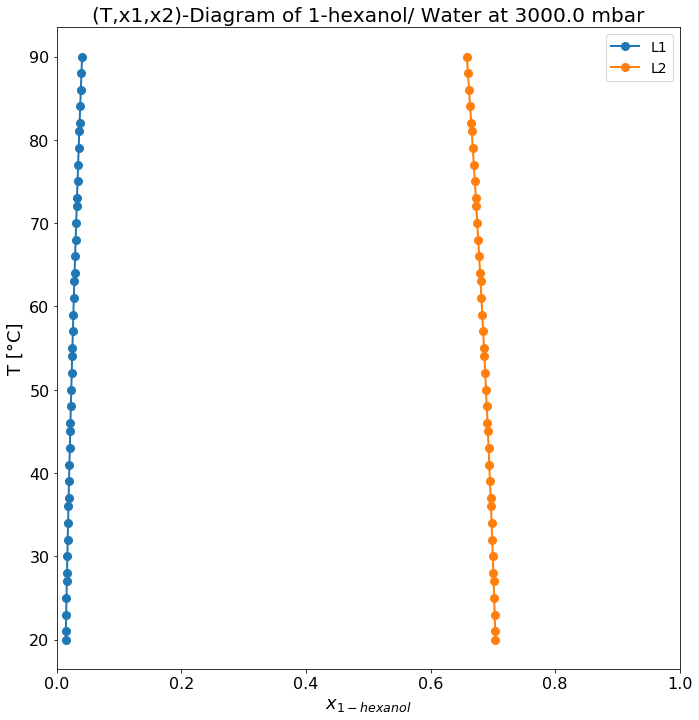

In [8]:
numSteps=40     
fig,ax=plt.subplots(1,1,figsize=(10,10))       
xvec=[]
x2vec=[]
yvec=[]
i=water
j=hexanol
psys=3000
mixture.Specify("P",psys, METRIC.mbar)

for T in np.linspace(20,90,numSteps):
    mixture.Specify("T",T, METRIC.C)
    solver.Solve(flowTx)                             
    xvec.append(mixture.GetVariable('xL['+i.ID+']').Val())               
    x2vec.append(mixture.GetVariable('xL2['+i.ID+']').Val())               
    yvec.append(mixture.GetVariable('T').Val()-273.15)               
    
ax.plot(xvec, yvec, marker='o')                
ax.plot(x2vec, yvec, marker='o')
ax.set_xlabel('$x_{'+i.ID+'}$')       
ax.set_ylabel('T [°C]')            
#ax.set_ylim([25,175])
ax.set_xlim([0,1])
ax.legend(["L1","L2"])  
plt.tight_layout()
plt.title(f'(T,x1,x2)-Diagram of {i.ID}/ {j.ID} at {psys:.1f} mbar');



In [9]:
print(logger.Flush())

Decomposition Result: V=21, E=21, Blocks=12, Singletons=8
Block Statistics:
   # Var # Blocks % Blocks
       1        8  66,67 %
       2        2  16,67 %
       3        1   8,33 %
       6        1   8,33 %
Problem NLAES was successfully solved (0,00 seconds)
Decomposition Result: V=21, E=21, Blocks=12, Singletons=8
Block Statistics:
   # Var # Blocks % Blocks
       1        8  66,67 %
       2        2  16,67 %
       3        1   8,33 %
       6        1   8,33 %
Problem NLAES was successfully solved (0,00 seconds)
Decomposition Result: V=21, E=21, Blocks=12, Singletons=8
Block Statistics:
   # Var # Blocks % Blocks
       1        8  66,67 %
       2        2  16,67 %
       3        1   8,33 %
       6        1   8,33 %
Problem NLAES was successfully solved (0,00 seconds)
Decomposition Result: V=21, E=21, Blocks=12, Singletons=8
Block Statistics:
   # Var # Blocks % Blocks
       1        8  66,67 %
       2        2  16,67 %
       3        1   8,33 %
       6        1   8,33